# Задание
В CSV-файлах представлены два датасета:

+ Список заказов интернет-магазина. Содержит следующие поля:
    + Уникальный ID заказа
    + ID товара в заказе
    + Заказанное количество данного товара
    + Уникальный ID покупателя
    + Признак дополнительного товара  
    

+ Справочник товаров  

Товары в заказах делятся на основные (is_additional=0) и «дополнительные» (бесплатная
продукция, которая идет к заказу, is_additional=1)  

Необходимо получить ответы на следующие вопросы:  

1. Для каждого вида доп. продукции нужно по посчитать – сколько в среднем заказывают
данного вида продукции на один основной товар (только среди заказов, содержащих
данный вид доп.продукции). Например, для доп.товара «Вилка» мы должны взять все
заказы, содержащие вилку, и поделить количество вилок на количество основных товаров
в заказе.  
2. Для каждого вида доп.продукции нужно получить ТОП-10 основных товаров, с которым
его заказывают чаще всего
3. Нужно получить список гостей, которые заказывают слишком много доп.продукции:
количество доп.продукции на один основной продукт в три раза выше среднего.
Интересуют только покупатели, совершившие три и более заказов.  

Для основных товаров будем использовать в названиях колонок и переменных префикс __main__, для дополнительных __additional__

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List
from collections import defaultdict, Counter

from IPython.display import display

%matplotlib inline

# Load and clean data

Файлы __sales.csv__ и __products.csv__ были преобразованы для работы в Ubuntu и python, а именно была изменена кодировка и ошибки в разметке csv файла  
Финальные версии файлов, используемые при решении имеют имена __sales_python.csv__ и __products_python.csv__

In [2]:
SALES_PATH = 'sales_python.csv'
PRODUCTS_PATH = 'products_python.csv'

In [3]:
sales_df = pd.read_csv(SALES_PATH)
products_df = pd.read_csv(PRODUCTS_PATH)

In [4]:
products_df = products_df.rename(columns={'id':'product_id', 'title':'product_name'})
products_df.sample(5)

,product_id,product_name
2759,7336,Пакет за 5 рублей
2767,7004,Макарун Маракуйя
2207,6285,Фасоль замороженная 500г
1864,5747,Бейгл с курицей 220г
187,3875,Хурма Азербайджан


In [5]:
sales_df = sales_df.rename(columns={'count': 'amount',
                                    'is_additional': 'additional_product'
                                    })
sales_df.head(1)

,order_id,product_id,amount,customer_id,additional_product
0,12856119,6083,"1,000",1655898,0


In [6]:
def convert_to_float(str_amount: str):
    """
    Convert Excel comma separated float to python float
    
    params:
    str_amount: str 
    
    return:
    float_amount: float
    
    """
    float_amount = float(str_amount.replace(',', '.'))
    return float_amount
    

In [7]:
sales_df.loc[:, 'amount'] = sales_df.amount.apply(convert_to_float)

In [8]:
print(sales_df.info())
sales_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            50000 non-null  int64  
 1   product_id          50000 non-null  int64  
 2   amount              50000 non-null  float64
 3   customer_id         50000 non-null  int64  
 4   additional_product  50000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 1.9 MB
None


,order_id,product_id,amount,customer_id,additional_product
0,12856119,6083,1.0,1655898,0
1,12856119,7147,1.0,1655898,0
2,12856119,3527,1.0,1655898,0
3,12856119,5589,1.0,1655898,0
4,12856119,3670,1.0,1655898,0
...,...,...,...,...,...
49995,14044524,3702,3.0,95692,0
49996,14044524,3701,2.0,95692,0
49997,14044524,7061,1.0,95692,0
49998,14044524,5130,1.0,95692,0


<AxesSubplot:xlabel='amount', ylabel='Count'>

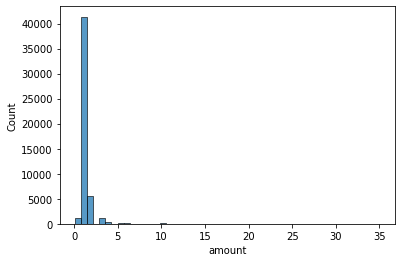

In [9]:
sns.histplot(sales_df.amount, bins=50)

В данных есть товары, у которых количество находится в диапазоне __0 < amount < 1__

In [10]:
sales_df['additional_order'] = sales_df.groupby('order_id', as_index=False)['additional_product'] \
    .transform('max')
sales_df.head(10)

,order_id,product_id,amount,customer_id,additional_product,additional_order
0,12856119,6083,1.0,1655898,0,1
1,12856119,7147,1.0,1655898,0,1
2,12856119,3527,1.0,1655898,0,1
3,12856119,5589,1.0,1655898,0,1
4,12856119,3670,1.0,1655898,0,1
5,12856119,5815,1.0,1655898,0,1
6,12856119,3700,1.0,1655898,0,1
7,12856119,7170,1.0,1655898,0,1
8,12856119,5816,1.0,1655898,0,1
9,12856119,5297,1.0,1655898,0,1


__additional_product__ - является ли данный товар дополнительным  
__additional_order__ - содержит ли данный заказ дополнительный товар

# Merge tables

In [11]:
common_df = sales_df.merge(products_df, how='left')
common_df.sample(5)

,order_id,product_id,amount,customer_id,additional_product,additional_order,product_name
36948,13944618,6052,1.0,619121,0,0,Булочка ржаная 45г
46690,14015023,5684,1.0,1625996,0,0,Молоко фермерское 4% 1л
37418,13946192,7335,1.0,627775,0,1,Раф соленая карамель ДОСТАВКА
11956,13807796,7622,1.0,523432,0,0,Пюре из тыквы на кокосовом молоке
37478,13946366,7210,1.0,95692,0,1,Блинчик с ветчиной и сыром 100гр


In [12]:
number_of_unique_additionals = common_df[common_df.additional_product == 1].product_id.nunique()
unique_additionals = list(common_df[common_df.additional_product == 1].product_name.unique())
print(f"Total number of additional products: {number_of_unique_additionals}")
print(
    f"All unique additional products:\n  {', '.join([' '.join(product.split(' ')[:2]) for product in unique_additionals])}")

Total number of additional products: 8
All unique additional products:
  Вилка черная, Сахар порционный, Палочки бамбуковые, Ложка черная, Соль порционная, Нож черный, Перец порционный, Палочки бамбуковые


In [13]:
def show_specific_order(order_id: int, df: pd.DataFrame):
    return df[df.order_id == order_id]

# Первое задание

Для каждого вида доп. продукции нужно посчитать – сколько в среднем заказывают данного вида продукции на один основной товар (только среди заказов, содержащих данный вид доп.продукции). Например, для доп.товара «Вилка» мы должны взять все заказы, содержащие вилку, и поделить количество вилок на количество основных товаров в заказе.  


In [14]:
def solve_first_task(data: pd.DataFrame, type: str = 'amount') -> pd.DataFrame:
    """
    type: str - allowed values 'amount' or 'unique'

    """

    data = data[data.additional_order == 1]

    if type == 'amount':

        main_quantity_df = data[data.additional_product == 0].groupby('order_id', as_index=False) \
            .agg(main_quantity=('amount', 'sum')) \
            .astype(int)
    else:

        main_quantity_df = data[data.additional_product == 0].groupby('order_id', as_index=False) \
            .agg(main_quantity=('product_id', 'count')) \
            .astype(int)

    additional_quantity_df = data[data.additional_product == 1].groupby(['order_id', 'product_id'], as_index=False) \
        .agg(additional_quantity=('amount', 'sum')) \
        .astype(int)

    main_with_additional = additional_quantity_df.merge(main_quantity_df, how='left')
    main_with_additional['additional_per_main'] = np.round(
        main_with_additional.additional_quantity / main_with_additional.main_quantity, 2)

    mean_by_additional = main_with_additional.groupby('product_id') \
        .agg(mean_additional_amount=('additional_per_main', 'mean')) \
        .reset_index() \
        .merge(products_df, how='left')

    return mean_by_additional


__Если считать отношение количества доп.продукции к *КОЛИЧЕСТВУ* основных товаров, т.е. к сумме *amount* по каждому основному товару, то решение выглядит так:__

In [15]:
solve_first_task(common_df, type='amount')

,product_id,mean_additional_amount,product_name
0,4478,0.244435,Палочки бамбуковые в индивидуальной упаковке
1,4479,0.424432,Сахар порционный Жизньмарт 5гр; шт
2,4480,0.360605,Соль порционная Жизньмарт 1гр; шт
3,4481,0.359874,Перец порционный Жизньмарт 0;25гр; шт
4,4816,0.381793,Нож черный
5,4817,0.448093,Вилка черная
6,5126,0.365149,Ложка черная
7,7042,0.264565,Палочки бамбуковые СТМ


__Если считать отношение количества доп.продукции к числу уникальных основных товаров в заказе, то решение немного поменяется:__

In [16]:
solve_first_task(common_df, type='unique')

,product_id,mean_additional_amount,product_name
0,4478,0.275565,Палочки бамбуковые в индивидуальной упаковке
1,4479,0.484205,Сахар порционный Жизньмарт 5гр; шт
2,4480,0.412177,Соль порционная Жизньмарт 1гр; шт
3,4481,0.425933,Перец порционный Жизньмарт 0;25гр; шт
4,4816,0.422253,Нож черный
5,4817,0.504696,Вилка черная
6,5126,0.403569,Ложка черная
7,7042,0.313333,Палочки бамбуковые СТМ


# Второе задание 
Для каждого вида доп.продукции нужно получить ТОП-10 основных товаров, с которым его заказывают чаще всего

Возможно, можно сделать решение чуть красивее и оптимальнее)

In [17]:
def solve_second_task(data: pd.DataFrame) -> pd.DataFrame:
    def ranking_main(data: pd.DataFrame) -> None:
        """
        data: pd.DataFrame grouped by order_id

        return: None, add values to top_main dict

        """

        main_products = list(data[data.additional_product == 0].product_name.values)
        additional_products = list(data[data.additional_product == 1].product_name.values)
        for additional in additional_products:
            top_main[additional] += main_products

    top_main = defaultdict(list)  # Храним здесь словарь вида: key - product_id доп.продукции, 
    # value - список всех основных товаров, которые с ним покупали 

    data[data.additional_order == 1].groupby('order_id', as_index=False) \
        .apply(ranking_main)

    top_cols = [f'top_{i}' for i in range(1, 11)]
    top_10_df = pd.DataFrame(columns=[['additional_product'] + top_cols])

    for index, (key, value) in enumerate(top_main.items()):

        top_10_df.loc[index, 'additional_product'] = key
        top_10_main_counter = Counter(value).most_common(10)

        for main_product_tuple, top_col in zip(top_10_main_counter, top_cols):
            top_10_df.loc[index, top_col] = main_product_tuple[0]

    return top_10_df

In [18]:
solve_second_task(common_df)

,additional_product,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,Вилка черная,Соевый соус; порц,Письмо новому клиенту,Суп-лапша куриный; шт,Картофельный крем-суп с беконом; шт,Имбирь; порц,Блинчик с ветчиной и сыром 100гр,Чизкейк банановый 100г,Васаби; порц,Онигири с куриным филе в соусе спайси Жизньмарт,Салат Оливье с мясом; шт
1,Сахар порционный Жизньмарт 5гр; шт,Капучино ДОСТАВКА,Латте ДОСТАВКА,Молоко обычное 200мл,Молоко обычное 270мл,Корица для кофе,Молоко банановое 200мл,Письмо новому клиенту,Соевый соус; порц,Смесь для чая Пряный с облепихой п/ф,Смесь для чая Малина - имбирь п/ф
2,Палочки бамбуковые в индивидуальной упаковке,Соевый соус; порц,Имбирь; порц,Васаби; порц,Ролл Филадельфия; шт (Жизнь Март),Ролл с лососем и огурцом; шт (Жизньмарт),Письмо новому клиенту,Ролл Тортилья с цыпленком гриль; шт (Жизнь Март),Ролл сливочный с лососем; шт (Жизнь Март),Ролл Чукка с снежным крабом; шт (Жизньмарт),Ролл Сурими со сливочным сыром
3,Ложка черная,Суп-лапша куриный; шт,Соевый соус; порц,Картофельный крем-суп с беконом; шт,Письмо новому клиенту,Чизкейк банановый 100г,Блинчик с ветчиной и сыром 100гр,Борщ с говядиной; шт,Торт медовый,Трубочка Крем-чиз Варенка 50г,Онигири с куриным филе в соусе спайси Жизньмарт
4,Соль порционная Жизньмарт 1гр; шт,Соевый соус; порц,Суп-лапша куриный; шт,Письмо новому клиенту,Картофельный крем-суп с беконом; шт,Чизкейк банановый 100г,Васаби; порц,Имбирь; порц,Салат Сельдь под шубой; шт,Торт медовый,Блинчик с ветчиной и сыром 100гр
5,Нож черный,Соевый соус; порц,Письмо новому клиенту,Блинчик с ветчиной и сыром 100гр,Чизкейк банановый 100г,Картофельный крем-суп с беконом; шт,Суп-лапша куриный; шт,Куриные наггетсы с дольками запеченного картофеля,Онигири с куриным филе в соусе спайси Жизньмарт,Грудка куриная с ананасами под сыром с картофе...,Салат Оливье с мясом; шт
6,Перец порционный Жизньмарт 0;25гр; шт,Соевый соус; порц,Суп-лапша куриный; шт,Письмо новому клиенту,Картофельный крем-суп с беконом; шт,Салат Сельдь под шубой; шт,Чизкейк банановый 100г,Торт медовый,Онигири с сурими Жизньмарт,Васаби; порц,Имбирь; порц
7,Палочки бамбуковые СТМ,Соевый соус; порц,Имбирь; порц,Васаби; порц,Ролл Филадельфия; шт (Жизнь Март),Ролл с лососем и огурцом; шт (Жизньмарт),Ролл сливочный с лососем; шт (Жизнь Март),Письмо новому клиенту,Ролл Тортилья с цыпленком гриль; шт (Жизнь Март),Ролл Сурими со сливочным сыром,Ролл Чукка с снежным крабом; шт (Жизньмарт)


# Третье задание
Нужно получить список гостей, которые заказывают слишком много доп.продукции: количество доп.продукции на один основной продукт в три раза выше среднего. Интересуют только покупатели, совершившие три и более заказов.

In [19]:
def solve_third_task(data: pd.DataFrame) -> pd.DataFrame:
    customer_total_additional = data[data.additional_product == 1].groupby('customer_id', as_index=False) \
        .agg(total_additional_amount=('amount', 'sum')) \
        .astype(int)

    customer_total_main = data[data.additional_product == 0].groupby('customer_id', as_index=False) \
        .agg(total_main_amount=('amount', 'sum')) \
        .astype(int)

    customer_total_products = customer_total_additional.merge(customer_total_main, how='left')
    customer_total_products['total_additional_per_main'] = np.round(
        customer_total_products.total_additional_amount / customer_total_products.total_main_amount, 2)

    mean_ratio = customer_total_products.total_additional_per_main.mean()

    desired_clients_ids = list(
        customer_total_products[customer_total_products.total_additional_per_main > 3 * mean_ratio][
            'customer_id'].values)
    print(
        'ID клиентов, у которых количество доп.продукции на один основной продукт в 3 раза выше среднего значения:\n ')
    print(', '.join([str(idx) for idx in desired_clients_ids]))
    print(f"\nТаких клиентов: {len(desired_clients_ids)} человек")

    return customer_total_products[customer_total_products.total_additional_per_main > 3 * mean_ratio]


In [20]:
additional_orders_df = common_df[common_df.additional_order == 1].copy()

number_of_orders_df = common_df.groupby('customer_id', as_index=False) \
    .agg(number_of_customer_orders=('order_id', 'nunique')) \
    .sort_values(by='number_of_customer_orders', ascending=False)

additional_orders_df = additional_orders_df.merge(number_of_orders_df, how='left')

more_than_2_orders_df = additional_orders_df[additional_orders_df.number_of_customer_orders > 2]

In [21]:
result_df = solve_third_task(more_than_2_orders_df)

ID клиентов, у которых количество доп.продукции на один основной продукт в 3 раза выше среднего значения:
 
420001, 425186, 466760, 627775, 686802, 831703, 834544, 862611, 965143, 1254019, 1387897, 1561950, 1613186, 1616639, 1619265, 1696232

Таких клиентов: 16 человек


In [22]:
result_df

,customer_id,total_additional_amount,total_main_amount,total_additional_per_main
111,420001,112,35,3.20
113,425186,15,5,3.00
126,466760,125,46,2.72
164,627775,42,17,2.47
181,686802,133,23,5.78
218,831703,50,15,3.33
220,834544,25,11,2.27
229,862611,37,12,3.08
251,965143,73,23,3.17
293,1254019,42,12,3.50
